##### Name - Shunottara Alhat

# Assignment 15 - Q2 - Use Random Forest to prepare a model on fraud data  treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

##### Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from time import time
from sklearn.tree import plot_tree


import warnings
warnings.filterwarnings('ignore')

##### Import Data 

In [2]:
FraudCheck = pd.read_csv("Fraud_check.csv")
FraudCheck

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


### Explorary Data Analysis 

In [3]:
# Info

FraudCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [4]:
# Missing Value

FraudCheck.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [5]:
# Shape
FraudCheck.shape

(600, 6)

In [6]:
# Duplicates
FraudCheck.duplicated().sum()

0

In [7]:
# Describe
FraudCheck.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


### Feature Engineering 

In [8]:
FraudCheck['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [9]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
FraudCheck1 = FraudCheck.copy()
FraudCheck1['Taxable_category'] = pd.cut(x = FraudCheck1['Taxable.Income'], bins = [10002,30000,99620], 
                                         labels = ['Risky', 'Good'])
FraudCheck1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


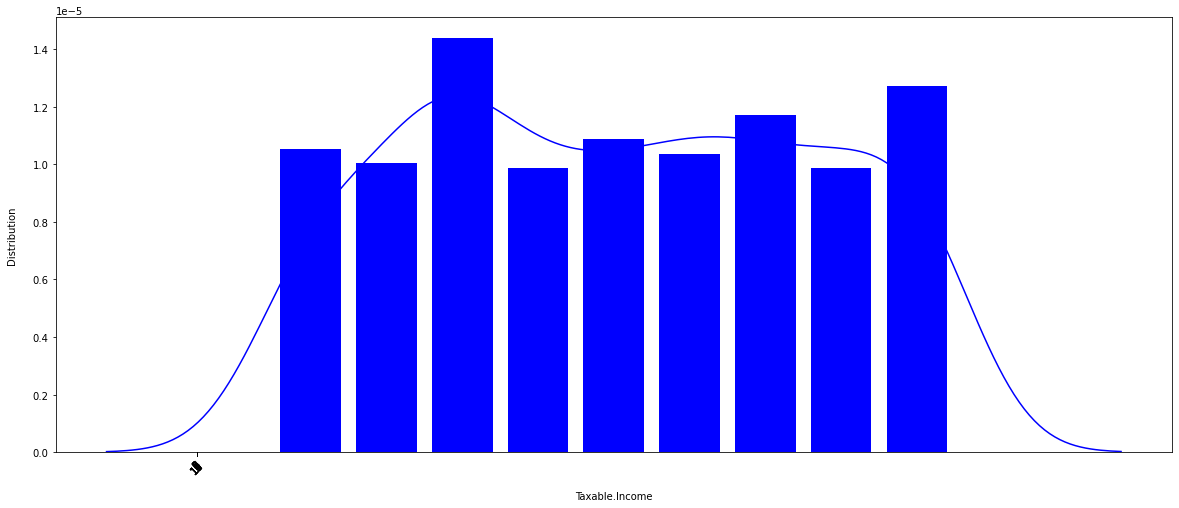

In [10]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(FraudCheck[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [11]:
FraudCheck1.Taxable_category.value_counts()

Good     476
Risky    124
Name: Taxable_category, dtype: int64

In [12]:
categorical_features = FraudCheck1.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban', 'Taxable_category'], dtype='object')

In [13]:
numerical_features = FraudCheck1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

### Data Visualization 

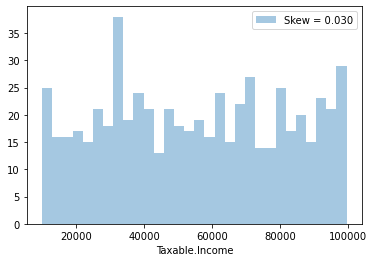

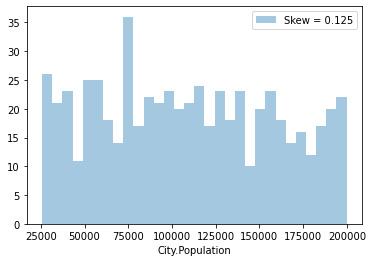

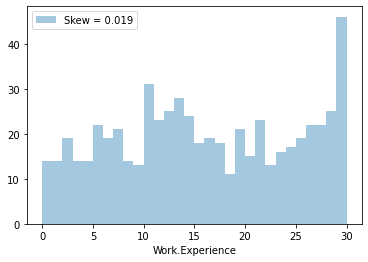

In [14]:
numerical_features=[feature for feature in FraudCheck.columns if FraudCheck[feature].dtypes != 'O']
for feat in numerical_features:
    skew = FraudCheck[feat].skew()
    sns.distplot(FraudCheck[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [15]:
# Detect observations with more than one outlier

def outlier_hunt(FraudCheck):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in FraudCheck.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(FraudCheck[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(FraudCheck[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = FraudCheck[(FraudCheck[col] < Q1 - outlier_step) | (FraudCheck[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(FraudCheck[numerical_features])))) 

The dataset contains 0 observations with more than 2 outliers


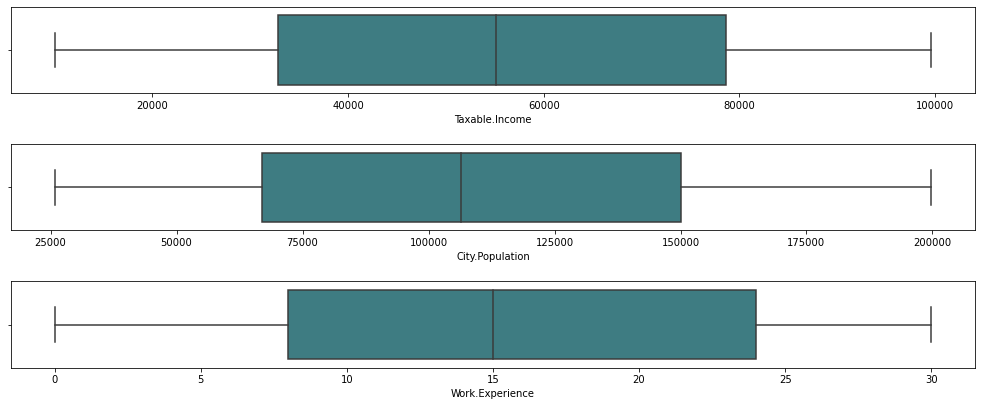

In [16]:
# OT is Outlier
OT = FraudCheck.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data= OT,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data= OT,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data= OT,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

<AxesSubplot:>

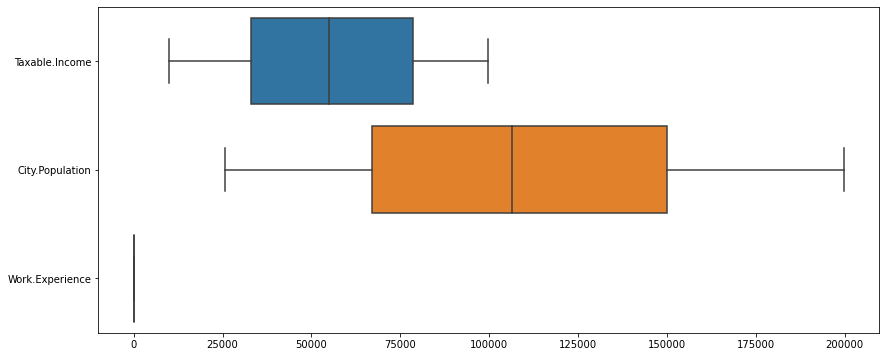

In [17]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data= FraudCheck[numerical_features], orient="h") 

<Figure size 576x576 with 0 Axes>

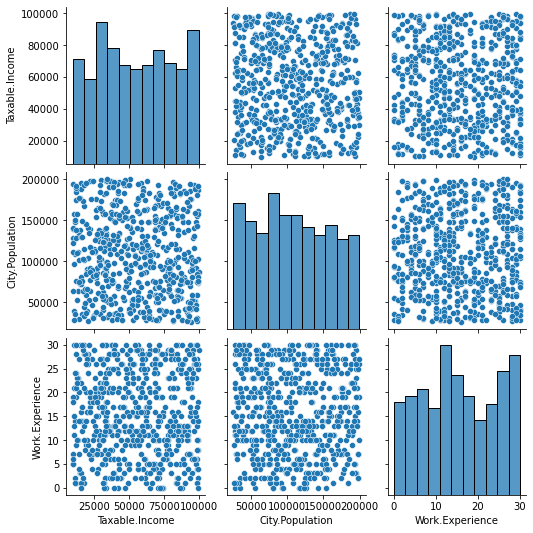

In [18]:
plt.figure(figsize=(8,8))
sns.pairplot(FraudCheck, palette='coolwarm')
plt.show()

#### Correlation 

<AxesSubplot:>

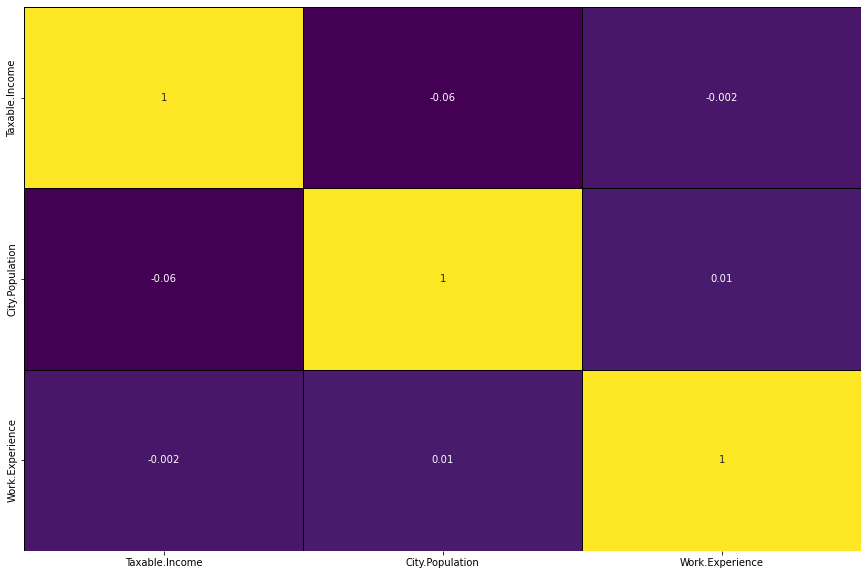

In [19]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(FraudCheck.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Index(['Undergrad', 'Marital.Status', 'Urban', 'Taxable_category'], dtype='object')


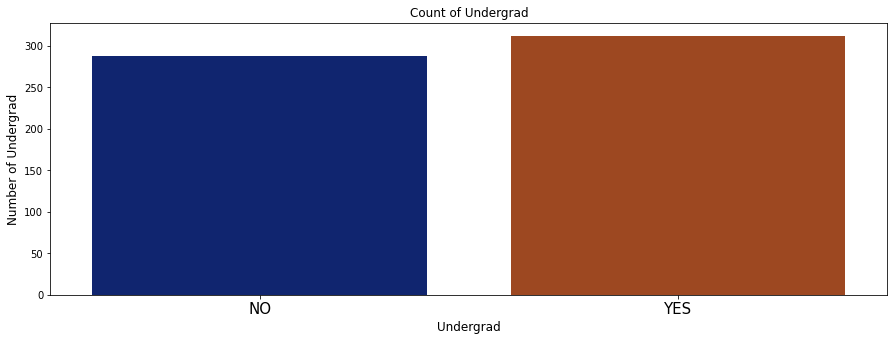

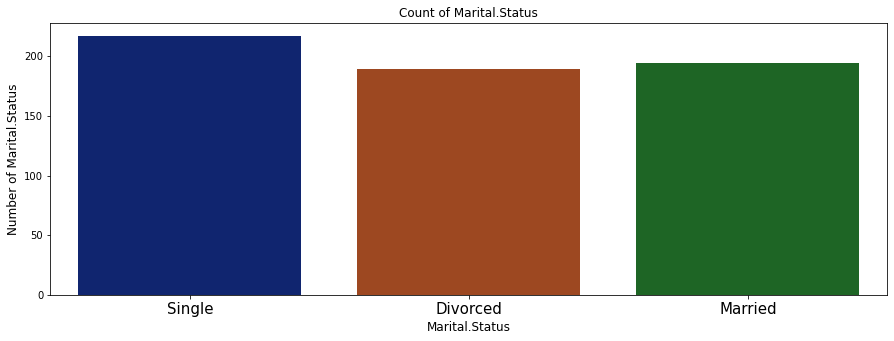

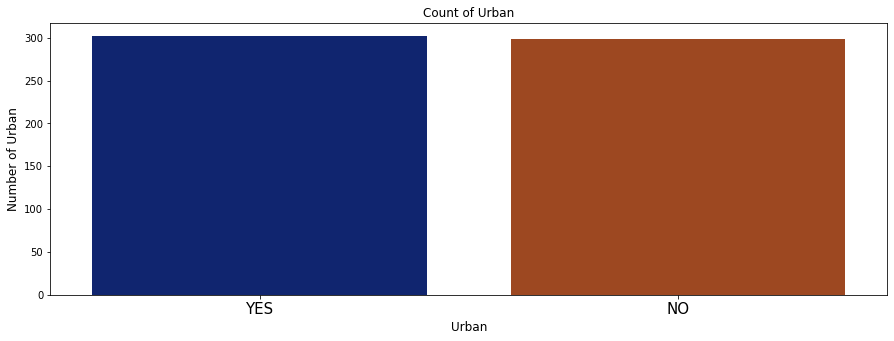

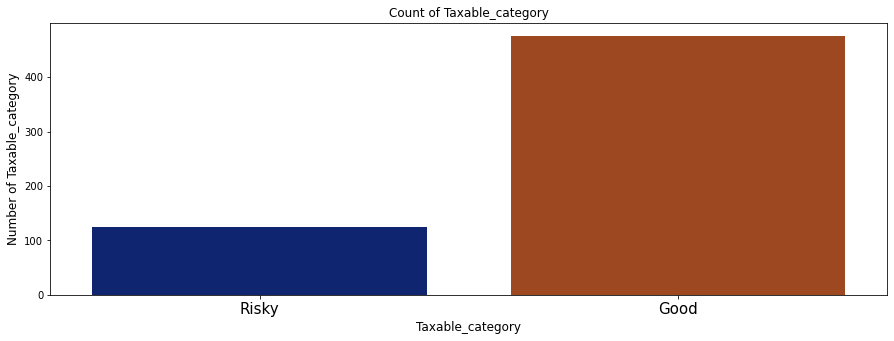

In [20]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = FraudCheck1[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data= FraudCheck1, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

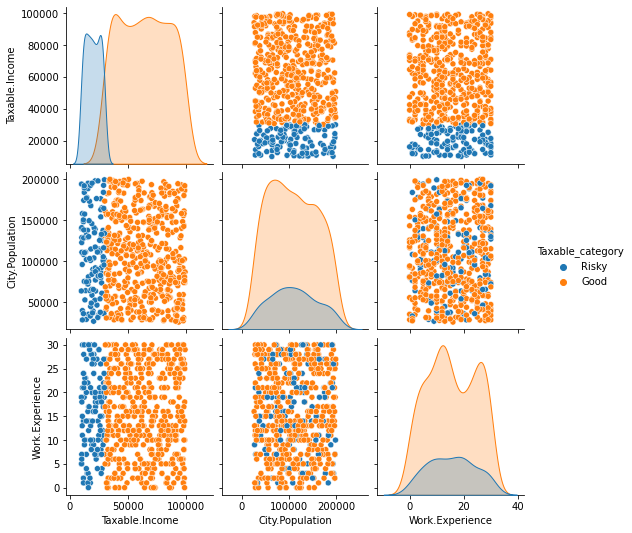

In [21]:
# let's plot pair plot to visualise the attributes all at once

sns.pairplot(data= FraudCheck1, hue = 'Taxable_category')

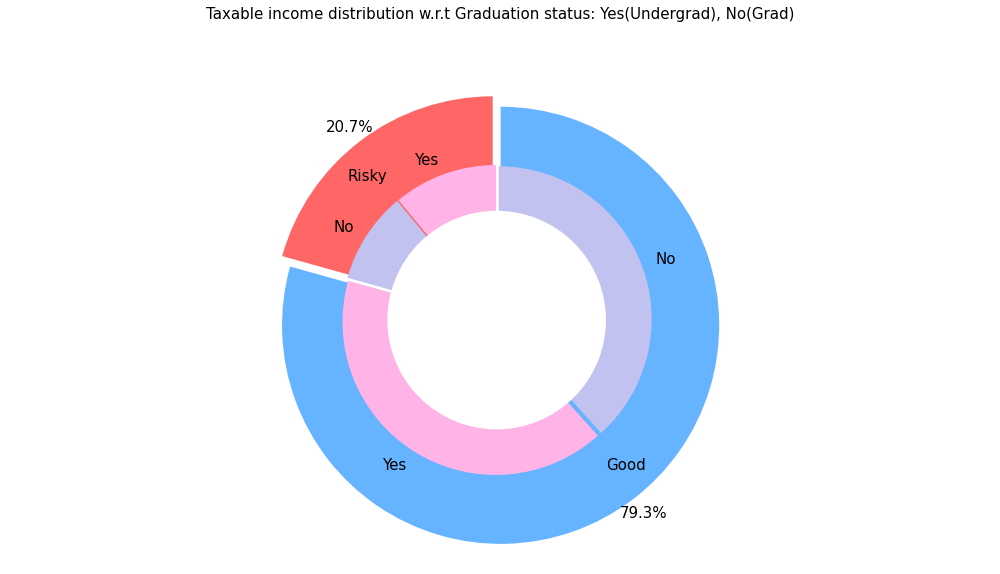

In [22]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [FraudCheck1["Taxable_category"][FraudCheck1["Taxable_category"] == 'Risky'].groupby
          (by = FraudCheck1.Undergrad).count().sum(),
         FraudCheck1["Taxable_category"][FraudCheck1["Taxable_category"] == 'Good'].
          groupby(by = FraudCheck1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, 
        explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, 
        textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Graduation status: Yes(Undergrad), No(Grad)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

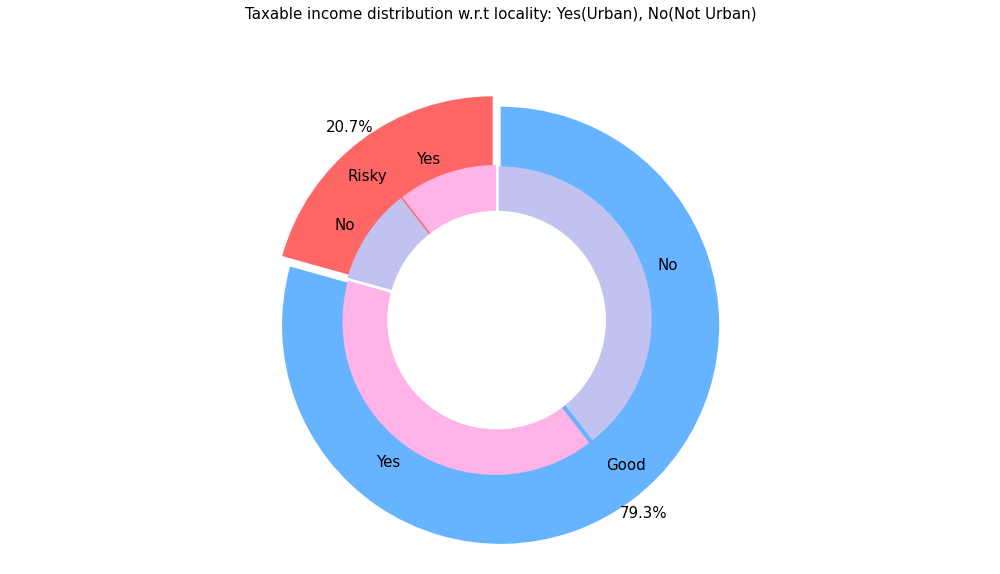

In [23]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [FraudCheck1["Taxable_category"][FraudCheck1["Taxable_category"] == 'Risky']
          .groupby(by = FraudCheck1.Urban).count().sum(),
         FraudCheck1["Taxable_category"][FraudCheck1["Taxable_category"] == 'Good']
          .groupby(by = FraudCheck1.Urban).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, 
        explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, 
        textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t locality: Yes(Urban), No(Not Urban)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

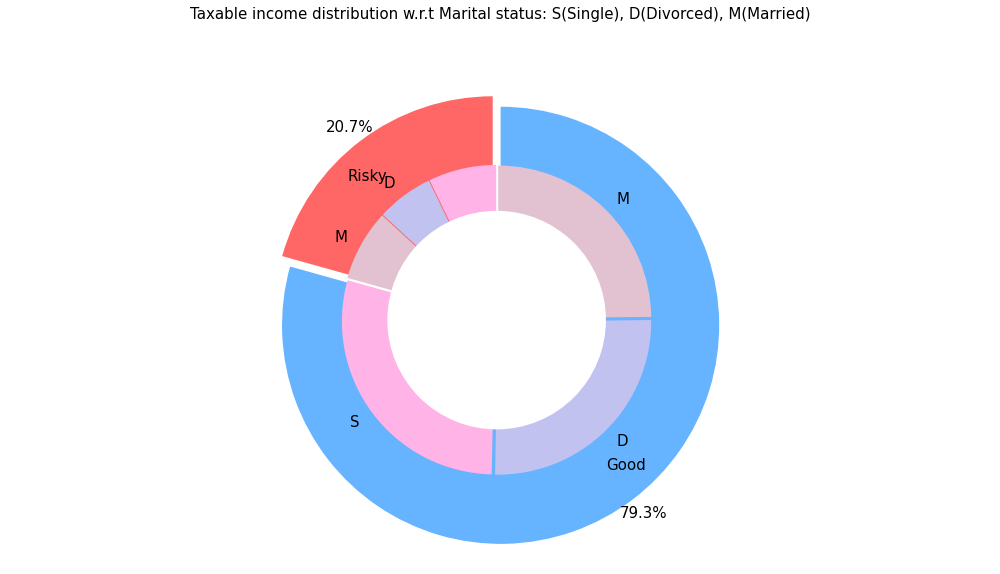

In [24]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [FraudCheck1["Taxable_category"][FraudCheck1["Taxable_category"] == 'Risky']
          .groupby(by = FraudCheck1["Marital.Status"]).count().sum(),
         FraudCheck1["Taxable_category"][FraudCheck1["Taxable_category"] == 'Good']
          .groupby(by = FraudCheck1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, 
        explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, 
        textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Marital status: S(Single), D(Divorced), M(Married)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()


In [25]:
Data_ = FraudCheck1.copy()
Data_.drop('Taxable.Income',axis=1, inplace =True)
Data_ = pd.get_dummies(Data_.iloc[:,:-1])
Data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


Text(0.5, 1.0, 'Correlation with Tax \n')

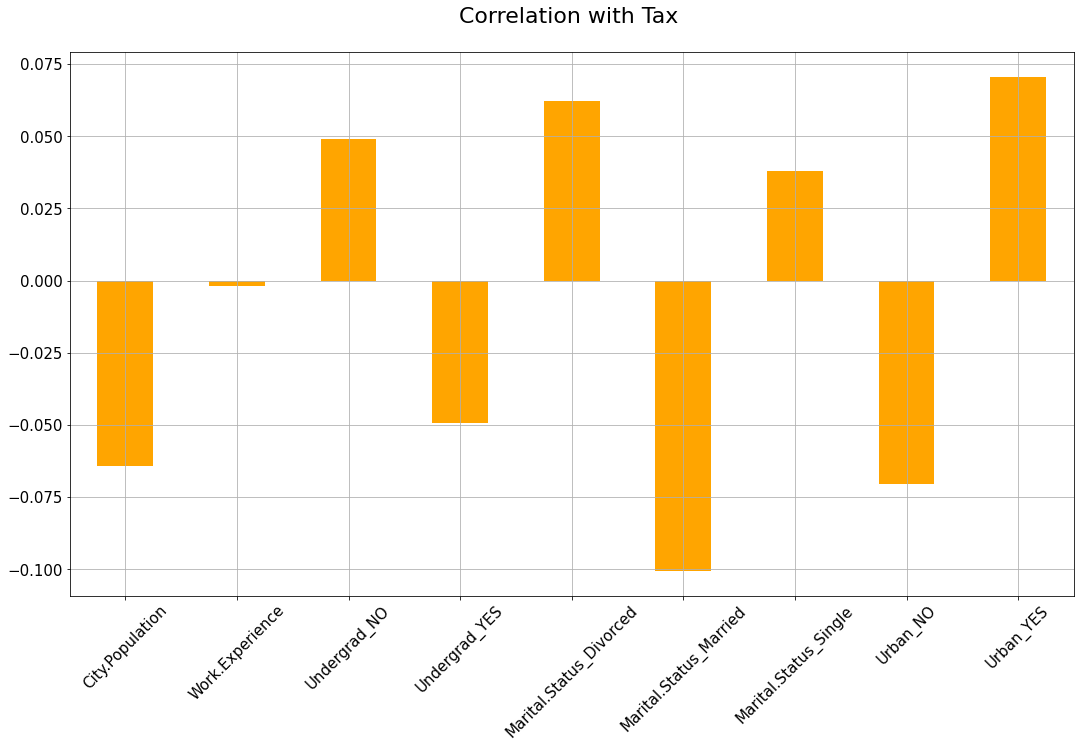

In [26]:
Data2 = Data_.copy()

correlations = Data2.corrwith(FraudCheck1['Taxable.Income'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize = (18, 10), fontsize = 15, color = 'orange',rot = 45, grid = True)
plt.title('Correlation with Tax \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

#### Checking for Imbalanced or balanced dataset with regards to the Target 

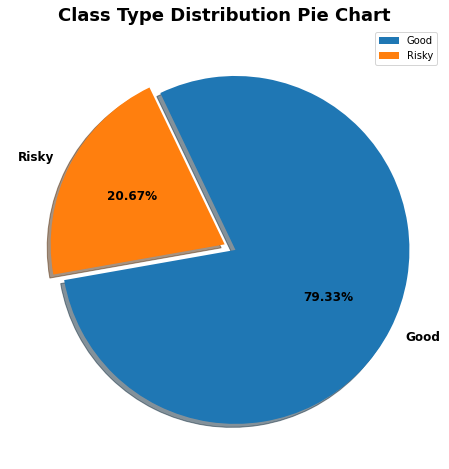

In [27]:
plt.figure(figsize = (12,8))
plt.pie(FraudCheck1['Taxable_category'].value_counts(),labels= FraudCheck1.Taxable_category.unique(),
       explode = [0.07,0.0],autopct= '%.2f%%',shadow= True,startangle= 190,
       textprops = {'size':'large','fontweight':'bold','rotation':'0','color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

In [28]:
countNotermdeposit = len(FraudCheck1[FraudCheck1['Taxable_category'] == 'Good'])
counthavetermdeposit = len(FraudCheck1[FraudCheck1['Taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%"
      .format((countNotermdeposit / (len(FraudCheck1.Taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%"
      .format((counthavetermdeposit / (len(FraudCheck1.Taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [29]:
FraudCheck1.Taxable_category.value_counts()

Good     476
Risky    124
Name: Taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

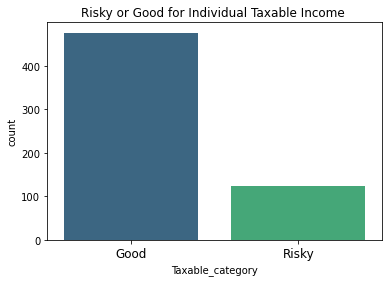

In [30]:
sns.countplot(x='Taxable_category', data= FraudCheck1, palette = 'viridis', 
              order= FraudCheck1['Taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

### Data Pre-Processing 

In [31]:
model_data = FraudCheck1.copy()
model_data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income',
                           'Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
model_data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = model_data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'Taxable_category'], dtype='object')

In [32]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(model_data[col])
        model_data[col] = le.transform(model_data[col])
model_data.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,Taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


In [33]:
# Data Pre-processing for feature Selection

Data_ = FraudCheck1.copy()
Data_.drop('Taxable.Income',axis=1, inplace =True)
Data_ = pd.get_dummies(Data_.iloc[:,:-1])
Data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


In [34]:
Data_['Taxable_Income'] = FraudCheck1.Taxable_category
Data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,Good
1,134075,18,0,1,1,0,0,0,1,Good
2,160205,30,1,0,0,1,0,0,1,Good
3,193264,15,0,1,0,0,1,0,1,Good
4,27533,28,1,0,0,1,0,1,0,Good


In [35]:
le = LabelEncoder()
le.fit(Data_["Taxable_Income"])
Data_["Taxable_Income"]=le.transform(Data_["Taxable_Income"])
Data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0


In [36]:
# split into input (X) and output (y) variables
X = Data_.iloc[:, :-1]

y=  Data_.Taxable_Income

In [37]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [38]:
# summarize scores
scores = fit.scores_

features = fit.transform(X)

In [39]:
score_df = pd.DataFrame(list(zip(scores, X.columns)),columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
0,2045.643886,City.Population
5,0.756912,Marital.Status_Married
4,0.302172,Marital.Status_Divorced
6,0.095850,Marital.Status_Single
2,0.048929,Undergrad_NO
3,0.045165,Undergrad_YES
1,0.011709,Work.Experience
7,0.007044,Urban_NO
8,0.006951,Urban_YES


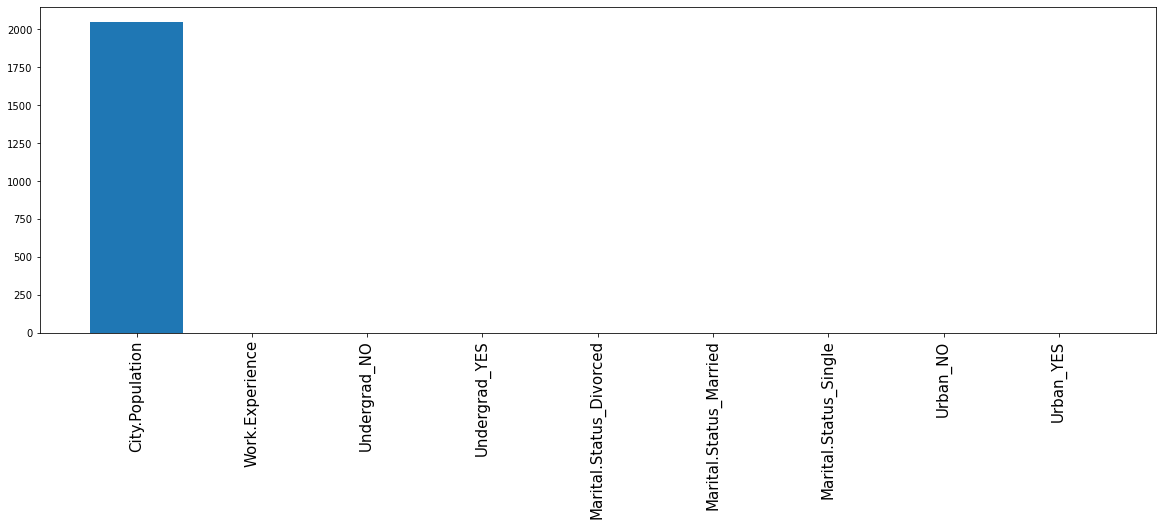

In [40]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

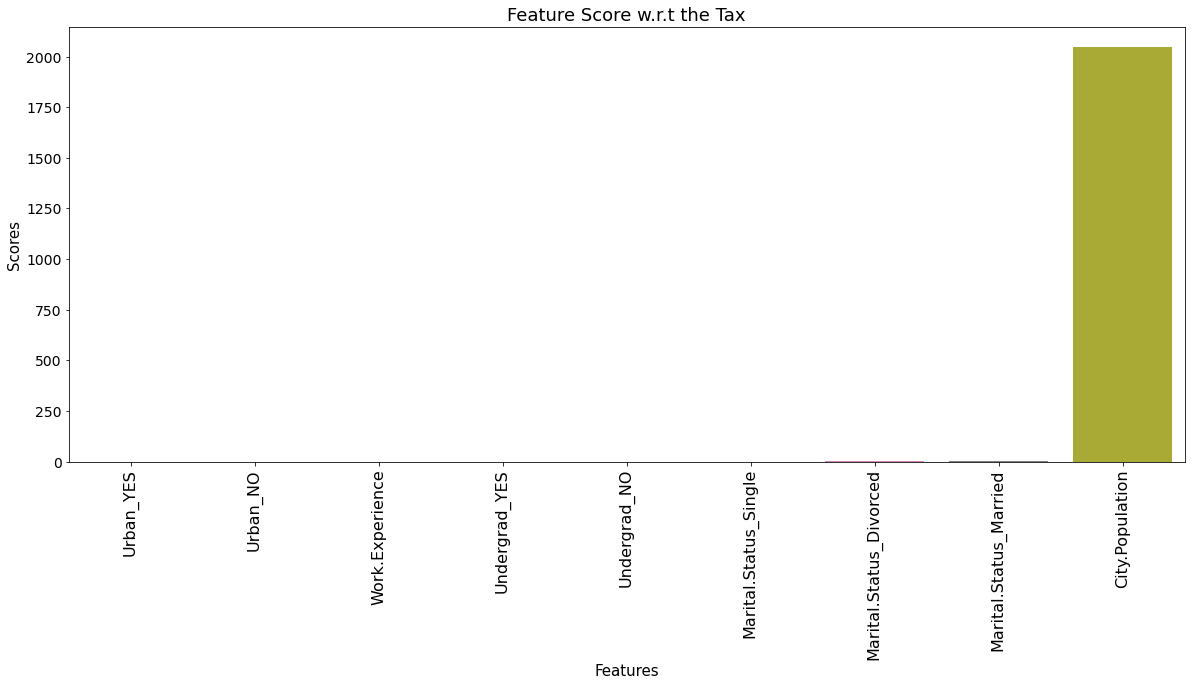

In [41]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',y="Score", data=score_df, order=score_df.sort_values('Score').Feature)

# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Tax", size=18)
plt.show()

### Random Forest Built-in Feature Importance 

In [42]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)

classifier_rf.fit(X, y)

# checking the oob score
print('checking the oob score',classifier_rf.oob_score_)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20],'min_samples_leaf': [5,10,20,50,100,200],'n_estimators': [10,25,30,50,100,200]}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,param_grid=params,cv = 4,n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X, y)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

checking the oob score 0.7933333333333333
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best Score 0.7933333333333333
RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


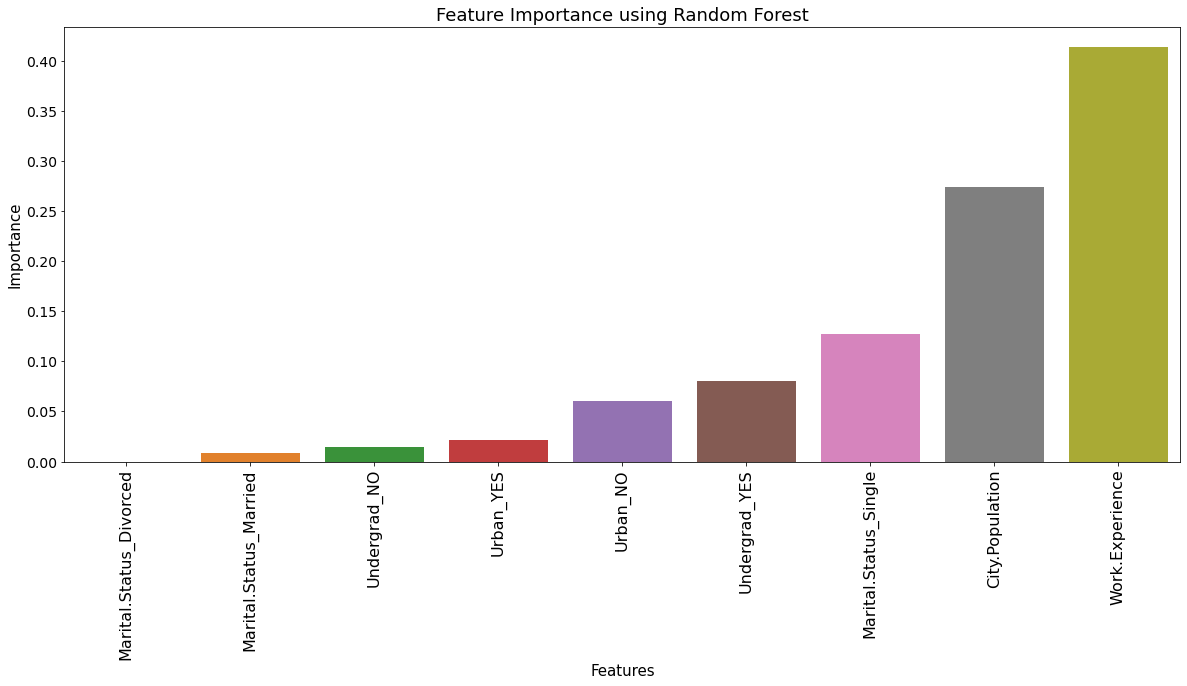

In [43]:
# Now let’s sort the data with the help of feature importance

rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": X.columns,"Importance": rf_best.feature_importances_})
plt.figure(figsize=(20,8))

# make barplot and sort bars
sns.barplot(x='Feature',y="Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)

# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Importance using Random Forest", size=18)
plt.show()

### Test Train Split 

In [44]:
model_data.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'Taxable_category'],
      dtype='object')

In [45]:
x = model_data.drop('Taxable_category',axis=1)
y = model_data['Taxable_category']

In [46]:
y.unique()

array([0, 1])

In [47]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 429, 1: 111}) Testing Data Counter({0: 47, 1: 13})


In [48]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [49]:
# summarize train and test composition
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 333, 1: 87}) Testing Data Counter({0: 143, 1: 37})


In [50]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### Grid search using Stratified Kfold Splits  

In [51]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [52]:

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_X, train_y)

print_score(rf_clf, train_X, train_y, test_X, test_y, train=True)
print_score(rf_clf, train_X, train_y, test_X, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    429.0  111.0       1.0      540.0         540.0
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  0 111]]

Test Result:
Accuracy Score: 73.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.771930   0.0  0.733333   0.385965      0.604678
recall      0.936170   0.0  0.733333   0.468085      0.733333
f1-score    0.846154   0.0  0.733333   0.423077      0.662821
support    47.000000  13.0  0.733333  60.000000     60.000000
_______________________________________________
Confusion Matrix: 
 [[44  3]
 [13  0]]


### Grid search using Train Test Splits Stratifying Target feature 

In [53]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
Accuracy Score: 74.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.783626   0.0  0.744444    0.391813      0.622547
recall       0.937063   0.0  0.744444    0.468531      0.744444
f1-score     0.853503   0.0  0.744444    0.426752      0.678061
support    143.000000  37.0  0.744444  180.000000    180.000000
_______________________________________________
Confusion Matrix: 
 [[134   9]
 [ 

# Random Forest

In [54]:
# Random Forest hyperparameter tuning

#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [55]:
loc = np.array(score_array).max()
score_array.index(loc)+1

176

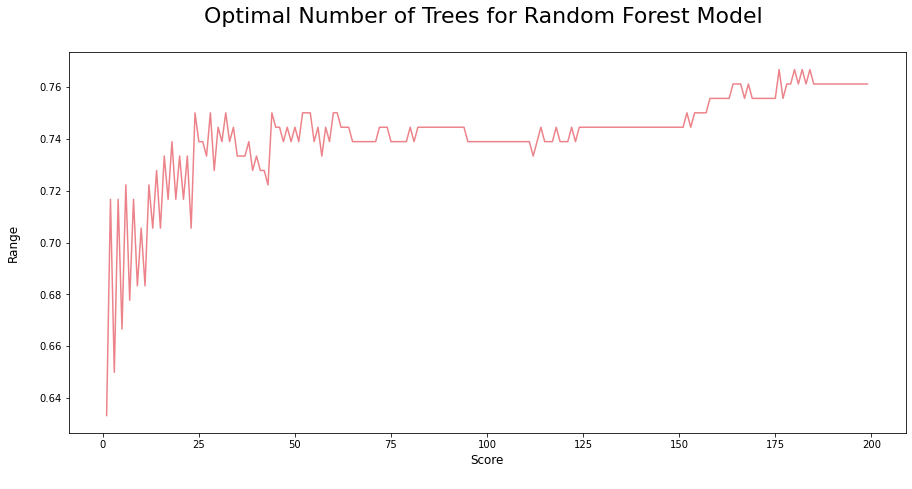

In [56]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", 
          fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()


#### Randomized Search Cross Validation 

In [57]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,'max_depth': max_depth, 
               'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 1, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True})
Train Result:
Accuracy Score: 78.33%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.820106   0.452381  0.783333    0.636243      0.743934
recall       0.930931   0.218391  0.783333    0.574661      0.783333
f1-score     0.872011   0.294574  0.783333    0.583292      0.752399
support    333.000000  87.000000  0.783333  420.000000    420.000000
_______________________________________________
Confusion Matrix: 
 [[310  23]
 [ 68  19]]

Test Result:
Accuracy Score: 71.67%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.787500   0.150000  0.716667    0.468750      0.656458


### Grid Search Cross Validation 

In [58]:
# Create a pipeline with a Random forest classifier

    
pipe_rfc = Pipeline([ ('scl', StandardScaler()), 
                    ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])

# Set the grid parameters
param_grid_rfc =  [ {'rfc__n_estimators': [100, 200,300,400], # number of estimators
    #'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
    'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
    'rfc__max_depth': [None, 5], # Max depth of the trees
    'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

#Fit the pipeline
start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 49.678 seconds
-------Best score----------
1.8181818181818181
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.01, 'rfc__n_estimators': 100}


### Visualizing one of the decision tree in random forest 

In [59]:
RF_best = rf_cv.best_estimator_
RF_best

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10, n_estimators=1,
                       random_state=42)

In [60]:
FraudCheck1.Taxable_category.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

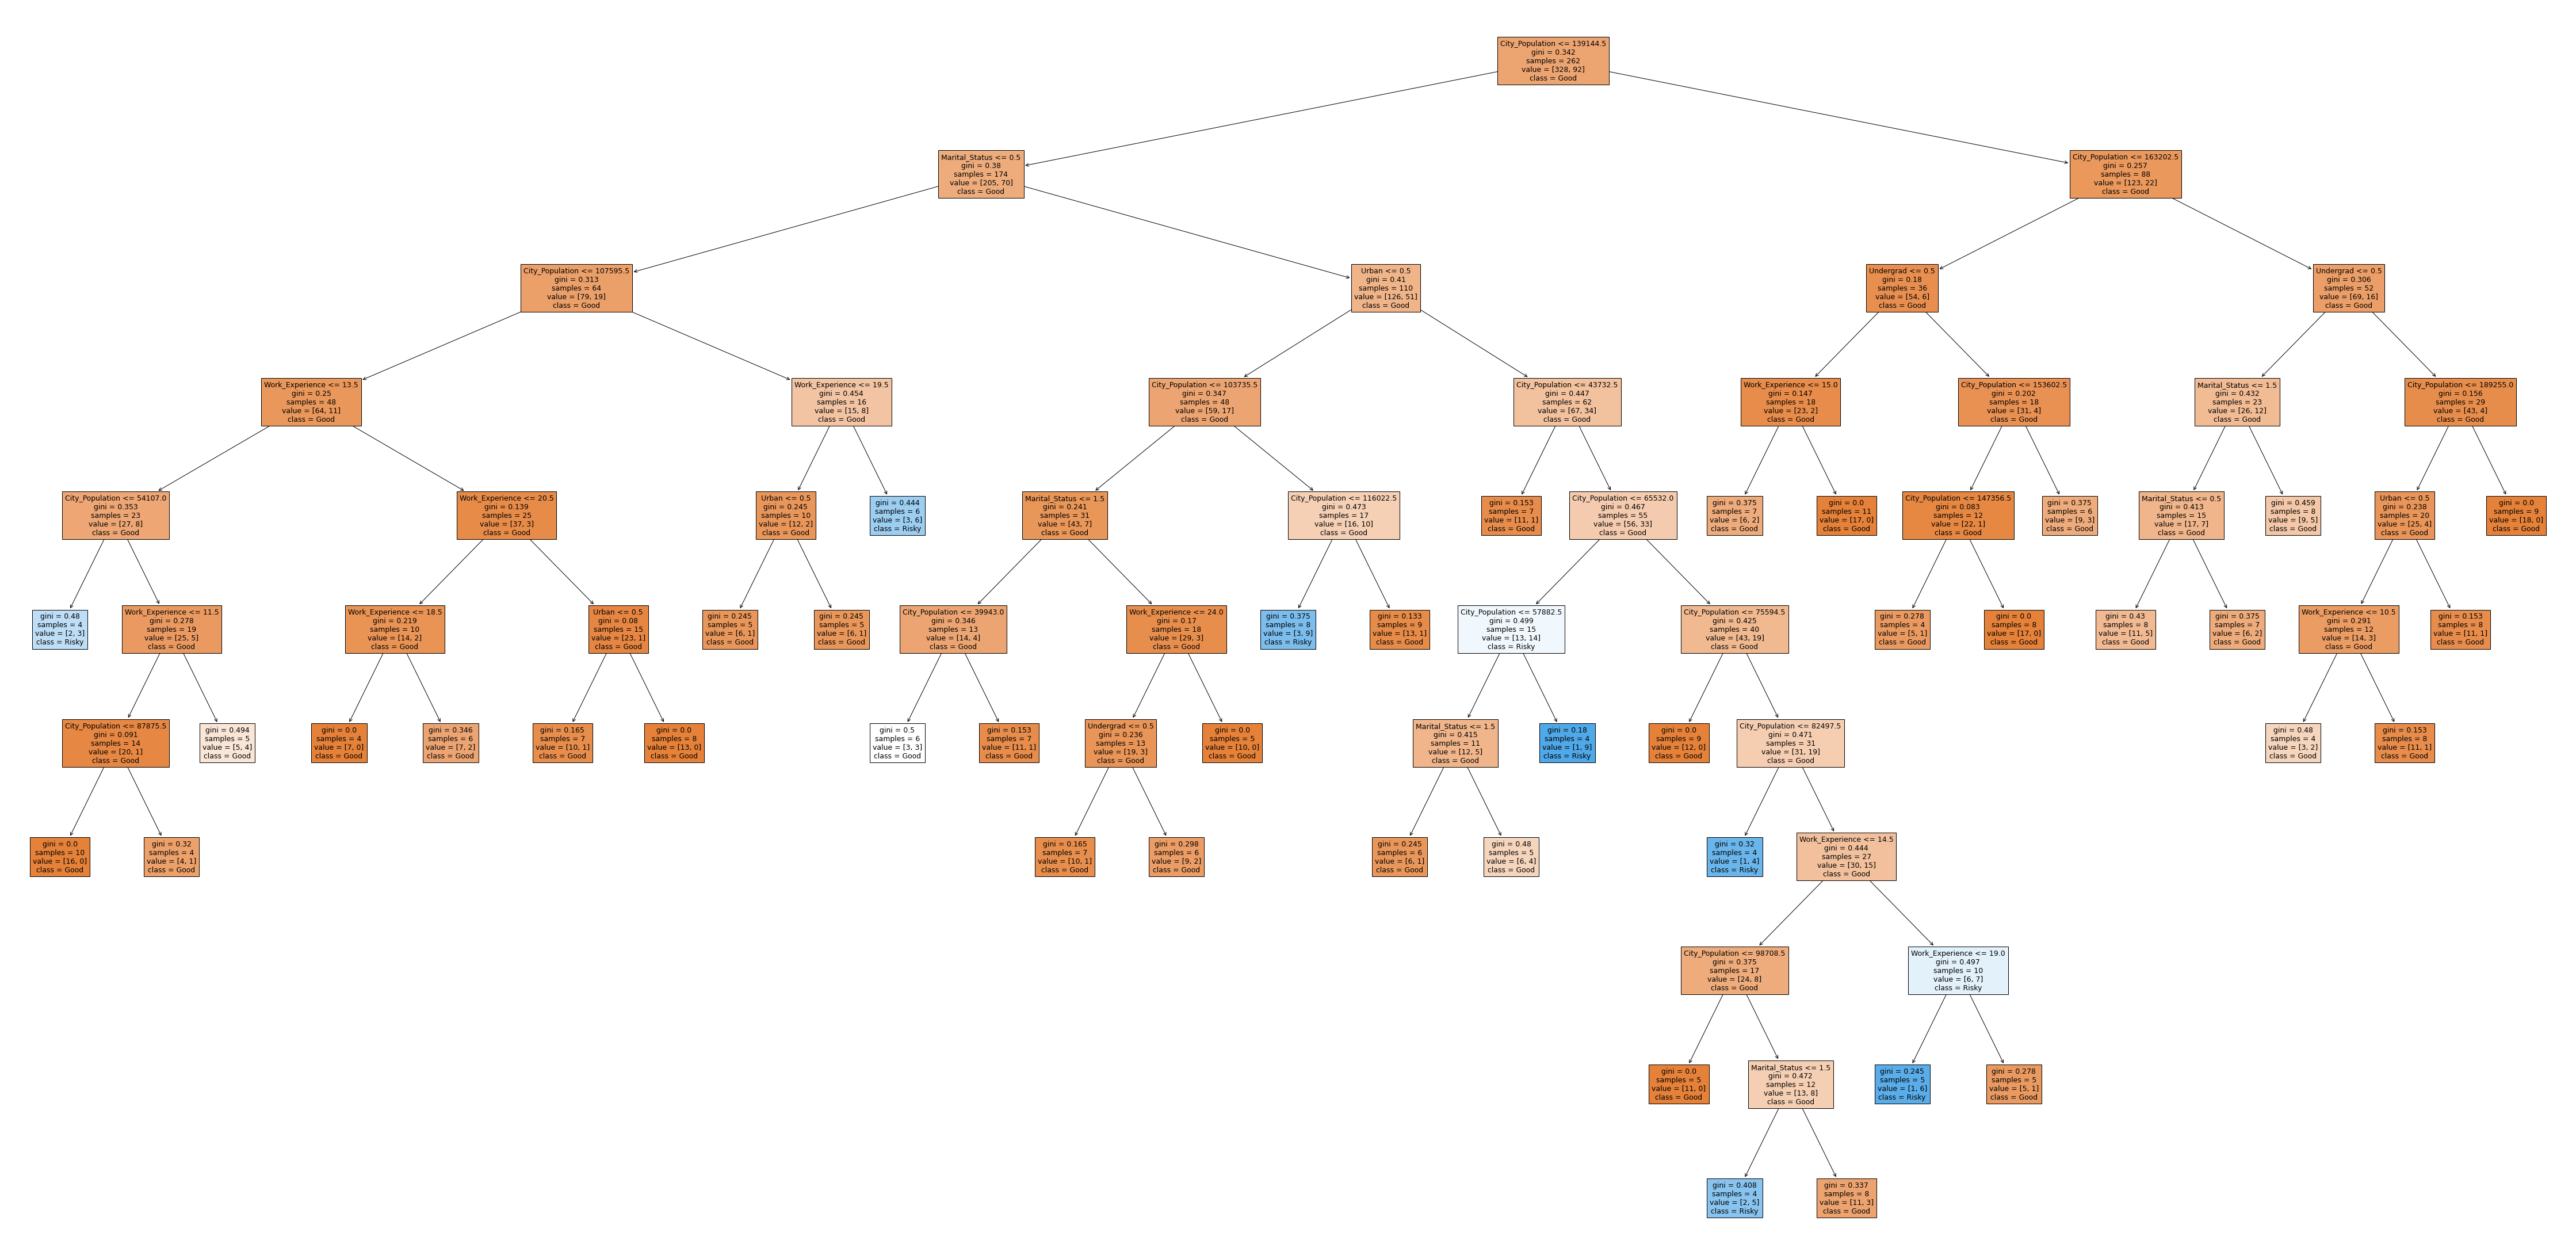

In [61]:
plt.figure(figsize=(80,40))
plot_tree(RF_best.estimators_[0], feature_names = model_data.columns,class_names= FraudCheck1.Taxable_category.unique(),
          filled=True)
plt.show()